---
layout: single
title: 'Computing raster statistics around buffered spatial points Python'
date: 2016-07-15
authors: [Matt Oakley, Max Joseph]
category: [tutorials]
excerpt: 'This tutorial shows how to compute raster statistics like the mean and variance around buffered spatial points in Python.'
sidebar:
  nav:
author_profile: false
comments: true
lang: [python]
lib: [geopy, osgeo, matplotlib, numpy, elevation]
---

One important thing we can do with data in Raster format is calculate statistical values such as mean, standard deviation, variance, etc. around points in the data. By doing so, we're able to find out attributes about the data and can generalize areas of it as opposed to dealing with every single individual cell.

## Objectives

- Read in a GeoTIFF
- Extract data from the raster at buffered point locations
- Compute statistics from these points

## Dependencies

- GDAL
- NumPy
- GeoPy
- Matplotlib
- elevation

In [1]:
from __future__ import division
from geopy.geocoders import Nominatim
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import elevation

%matplotlib inline

## Read in the Data

Our first objective is to read in the data that we want to use. We'll be working with .tiff image files and reading these in as numpy arrays. By doing so, we'll be able to essentially "view" our image as a 2D array where each cell corresponds to some value stored in each pixel of the image.

In [2]:
!eio selfcheck

Your system is ready.


In [3]:
!eio clip -o Shasta-30m-DEM.tif --bounds -122.6 41.15 -121.9 41.6 

make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -122.6 41.6 -121.9 41.15 SRTM1.vrt /Users/majo3748/Documents/earthlab/tutorials/python/Shasta-30m-DEM.tif


In [4]:
#Read in the data
filename = "Shasta-30m-DEM.tif"
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()
data_array = gdal_data.ReadAsArray().astype(np.float)
data_array

array([[ 1066.,  1064.,  1064., ...,  1450.,  1451.,  1451.],
       [ 1067.,  1065.,  1064., ...,  1451.,  1452.,  1452.],
       [ 1067.,  1065.,  1064., ...,  1452.,  1452.,  1453.],
       ..., 
       [ 1589.,  1594.,  1592., ...,  1089.,  1091.,  1093.],
       [ 1591.,  1595.,  1592., ...,  1069.,  1068.,  1070.],
       [ 1598.,  1599.,  1596., ...,  1049.,  1048.,  1051.]])

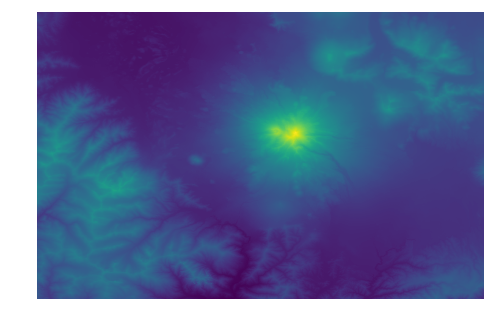

In [5]:
# replace missing values if necessary
if np.any(data_array == nodataval):
    data_array[data_array == nodataval] = np.nan

#View the data we're using
plt.figure(figsize = (8, 8))
plt.axis("off")
img = plt.imshow(data_array, cmap = "viridis")

Our goal is to extract information from this raster around a point. To define a spatial location, we need to know what the projection is for our digital elevation model. We can do this with the `GetProjection` method:

In [6]:
prj = gdal_data.GetProjection()
print prj

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]


## Extracting raster data around point locations

Now that we've read in our data, and we know what spatial coordinate system we are in, we're ready to extract a subset of this data that we want to compute statistics on. In doing so, we'll be able to get averages and other attributes from an area of our data as opposed to simply looking at individual values from pixels. Let's extract these points from a circular buffer that we'll place onto the data.

We'll first need to define where to center our circle buffer. Let's do this by using the central lat/lon coordinates for the city of Mt. Shasta, which we'll get by using the GeoPy module.

In [7]:
# Find coordinates of where we want to center our circle
def get_latlon(city_name):
    geolocator = Nominatim()
    latlon = geolocator.geocode(city_name)
    return latlon

coords = get_latlon("Mt. Shasta, CA")
coords

Location((41.3098746, -122.3105665, 0.0))

Next, we need to find the row and column index for our point, which is currently defined as a latitude/longitidue tuple. 

In [8]:
#Get row and column in raster based upon coordinates
#This is where we'll center the circle
def get_coords_at_point(rasterfile, pos):
    gdata = gdal.Open(rasterfile)
    gt = gdata.GetGeoTransform()
    data = gdata.ReadAsArray().astype(np.float)
    row = int((pos[1] - gt[0])/gt[1])
    col = int((pos[0] - gt[3])/gt[5])
    return col, row

radius = 60 # in units of pixels

row, col = get_coords_at_point(filename, pos = coords[1]) 
circle = (row, col, radius)

In [9]:
#Extract the points within the circle
def points_in_circle(circle, arr):
    buffer_points = []
    i0, j0, r = circle
    
    def int_ceiling(x):
        return int(np.ceil(x))
    
    for i in xrange(int_ceiling(i0 - r), int_ceiling(i0 + r)):
        ri = np.sqrt(r**2 - (i - i0)**2)
        
        for j in xrange(int_ceiling(j0 - ri), int_ceiling(j0 + ri)):
            buffer_points.append(arr[i][j])
            arr[i][j] = np.nan
    
    return buffer_points

buffer_points = points_in_circle(circle, data_array)

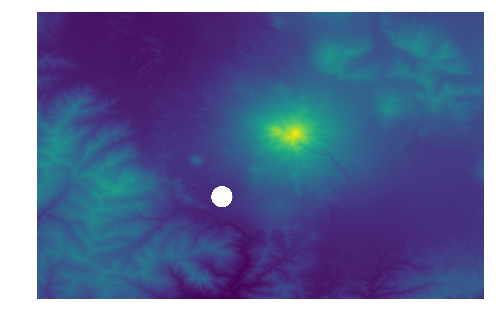

In [10]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
plt.axis("off")
img = plt.imshow(data_array, cmap = "viridis")

## Compute Statistics

Now that we have all of the values within the buffer/area, we can use NumPy to compute statistics such as mean, standard deviation, and variance on the data.

In [11]:
mean = np.nanmean(buffer_points)
std = np.nanstd(buffer_points)
variance = np.nanvar(buffer_points)

print "Mean: %.2f" % mean
print "Standard Deviation: %.2f" % std
print "Variance: %.2f" % variance

Mean: 1095.14
Standard Deviation: 41.65
Variance: 1734.41
